In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import librosa
import librosa.display
import IPython.display as ipd
import os
import pathlib
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [45]:
#Generating spectograms for every song
plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for genre in genres:
    pathlib.Path('spectograms/{}'.format(genre)).mkdir(parents = True, exist_ok = True)
    
    for fileName in os.listdir('/home/arek/kodzik/data_science/music_genre_classification/genres/{}'.format(genre)):
        songName = '/home/arek/kodzik/data_science/music_genre_classification/genres/{}/{}'.format(genre, fileName)
        y, sr = librosa.load(songName, mono = True, duration = 5)
        plt.specgram(y, NFFT = 2048, Fs = 2, scale = 'dB')
        plt.axis(False)
        plt.savefig(f'spectograms/{genre}/{fileName[:-3].replace(".", "")}.png')
        plt.clf()

/home/arek/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 720x720 with 0 Axes>

In [56]:

header = "filename chroma_fq rmse spectral_centroid spectral_bandwith rolloff zero_crossing_rate"

for i in range(1, 21):
    header += " mfcc{}".format(i)

header += " genre"
header = header.split()

In [72]:
#Extracting features and writing to csv
file = open("data.csv", 'w', newline = '')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for genre in genres:
    for filename in os.listdir('/home/arek/kodzik/data_science/music_genre_classification/genres/{}'.format(genre)):
        songname = '/home/arek/kodzik/data_science/music_genre_classification/genres/{}/{}'.format(genre, filename)
        y, sr = librosa.load(songname, mono = True, duration = 30)
        rms = librosa.feature.rms(y)
        chroma_stft = librosa.feature.chroma_stft(y, sr)
        spectral_centroid = librosa.feature.spectral_centroid(y, sr)
        spectral_bandwith = librosa.feature.spectral_bandwidth(y, sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y, sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y, sr)
        mfcc = librosa.feature.mfcc(y, sr)
        
        row = "{} {} {} {} {} {} {}".format(songname, np.mean(chroma_stft), np.mean(rms), 
                                         np.mean(spectral_centroid), np.mean(spectral_bandwith), 
                                         np.mean(spectral_rolloff), np.mean(zero_crossing_rate))
        
        for ce in mfcc:
            row += " {}".format(np.mean(ce))
            
        row += " {}".format(genre)
        
        file = open("data.csv", 'a', newline = '')
        with file:
            writer = csv.writer(file)
            writer.writerow(row.split())
        

In [2]:
music_df = pd.read_csv("data.csv")
music_df.head()

,filename,chroma_fq,rmse,spectral_centroid,spectral_bandwith,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,/home/arek/kodzik/data_science/music_genre_cla...,0.291884,0.116570,2371.099278,2209.699346,5004.111407,0.124573,-121.408836,96.106079,-19.613256,...,6.793616,-19.333881,-0.114447,-12.250432,-4.927437,-10.409580,-2.049566,-1.768211,-3.962158,blues
1,/home/arek/kodzik/data_science/music_genre_cla...,0.356588,0.162028,2068.371125,2033.930047,4231.499413,0.103511,-95.436028,105.216698,-26.953011,...,10.262574,-9.438187,3.867534,-10.187452,3.588093,-3.100752,0.194597,0.842872,-3.416576,blues
2,/home/arek/kodzik/data_science/music_genre_cla...,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.126384,-26.929785,107.334000,-46.809990,...,14.336612,-13.821767,7.562788,-6.181373,0.330166,-6.829571,0.965923,-7.570825,2.918987,blues
3,/home/arek/kodzik/data_science/music_genre_cla...,0.365575,0.219080,2645.681661,2426.198512,5612.507729,0.135699,-52.693062,74.430283,-18.692438,...,7.792499,-10.561926,6.946956,-9.127866,13.020091,-9.854002,3.689460,-4.947726,4.426066,blues
4,/home/arek/kodzik/data_science/music_genre_cla...,0.377519,0.111001,2302.113047,2367.695875,5188.551959,0.097378,-159.544983,69.779602,-4.396420,...,9.683710,-2.589124,3.307305,-14.966981,10.235810,-4.084133,-5.850184,-2.474234,6.650419,blues


In [3]:
music_df = music_df.drop(["filename"], axis = 1)
X = music_df.loc[:, "chroma_fq" : "mfcc20"]
y = music_df["genre"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 45, test_size = 0.3, stratify = y)
#Stratified K Fold for equal classes distribution in train test split

In [4]:
model_lr = LogisticRegression(solver = "newton-cg", multi_class = "multinomial", max_iter = 2000)
model_lr.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
y_predict_lr = model_lr.predict(X_test)
print(model_lr.score(X_test, y_test))

0.6233333333333333


In [39]:
#Hyperparameter tuning for logistic regression
C = np.logspace(-4, 4, 20)
solver = ["newton-cg", "lbfgs", "sag", "saga"]

lr_random_grid = {"C" : C, "solver" : solver}

In [40]:
lr_random_CV = RandomizedSearchCV(estimator = model_lr, param_distributions = lr_random_grid, 
                                  n_iter = 500, cv = 3)

lr_random_CV.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 80 is smaller than n_iter=500. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/li

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the 

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converg

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=2000,
                                                multi_class='multinomial',
                                                n_jobs=None, penalty='l2',
                                                random_state=None,
                                                solver='newton-cg', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=500, n_jobs=None,
                   pa...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84

In [41]:
lr_random_CV.best_params_

{'solver': 'newton-cg', 'C': 1438.44988828766}

In [6]:
#best_params_lr = {'solver': 'newton-cg', 'C': 1438.44988828766}
best_random_lr = LogisticRegression(solver = "newton-cg", C = 1438.44988828766)
best_random_lr.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/arek/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The l

LogisticRegression(C=1438.44988828766, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
y_pred_best_lr = best_random_lr.predict(X_test)

In [8]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
y_predict_rf = model_rf.predict(X_test)
print(model_rf.score(X_test, y_test))

0.5666666666666667


In [46]:
#Hyperparameter tuning for Random Forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
max_features = ["auto", "log2"]
max_depth = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20, 25]
min_samples_leaf = [1, 2, 5, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [48]:
rf_random_CV = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, 
                                  n_iter = 500, cv = 3)

rf_random_CV.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

In [49]:
rf_random_CV.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 60,
 'bootstrap': False}

In [10]:
#{'n_estimators': 1600,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'log2',
# 'max_depth': 60,
# 'bootstrap': False}
#best_rf = rf_random_CV.best_estimator_
best_rf = RandomForestClassifier(n_estimators = 1600, min_samples_split = 2, 
                                min_samples_leaf = 2, max_features = "log2",
                                max_depth = 60, bootstrap = False)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=60, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
y_pred_best_rf = best_rf.predict(X_test)

In [4]:
#SVM
model_svm = SVC(kernel = "poly", gamma = "scale")
model_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [5]:
y_pred_svm = model_svm.predict(X_test)

In [6]:
#SVM hyperparameters tuning
C = [1, 10, 100, 1000, 1500, 2000]
gamma = [x for x in np.logspace(-3, 2, 6)]
degree = [2, 3, 4, 5, 6]

random_grid_svm = {"C" : C, "degree" : degree, "gamma" : gamma}

In [ ]:
svm_random_cv = RandomizedSearchCV(estimator = model_svm, param_distributions = random_grid_svm, 
                                  n_iter = 200, cv = 3)

svm_random_cv.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 180 is smaller than n_iter=200. Running 180 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
svm_random_cv.best_params_

In [ ]:
best_svm = SVC(kernel = "poly", degree = 3, C = 2000)
best_svm.fit(X_train, y_train)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [21]:
print("Logistic regression accuracy = {}".format(model_lr.score(X_test, y_test)))
print("Logistic regression accuracy after hyperparameter tuning = {}".format(best_random_lr.score(X_test, y_test)))
print("Random Forest accuracy = {}".format(model_rf.score(X_test, y_test)))
print("Random Forest accuracy after hyperparameter tuning = {}".format(best_rf.score(X_test, y_test)))
print("SVM accuracy = {}".format(model_svm.score(X_test, y_test)))

Logistic regression accuracy = 0.6233333333333333
Logistic regression accuracy after hyperparameter tuning = 0.66
Random Forest accuracy = 0.5666666666666667
Random Forest accuracy after hyperparameter tuning = 0.6266666666666667
SVM accuracy = 0.2733333333333333


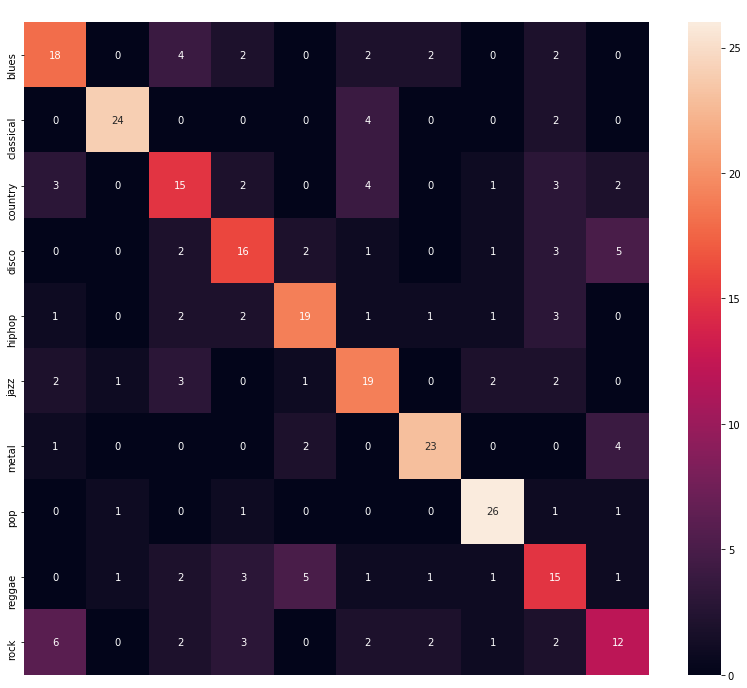

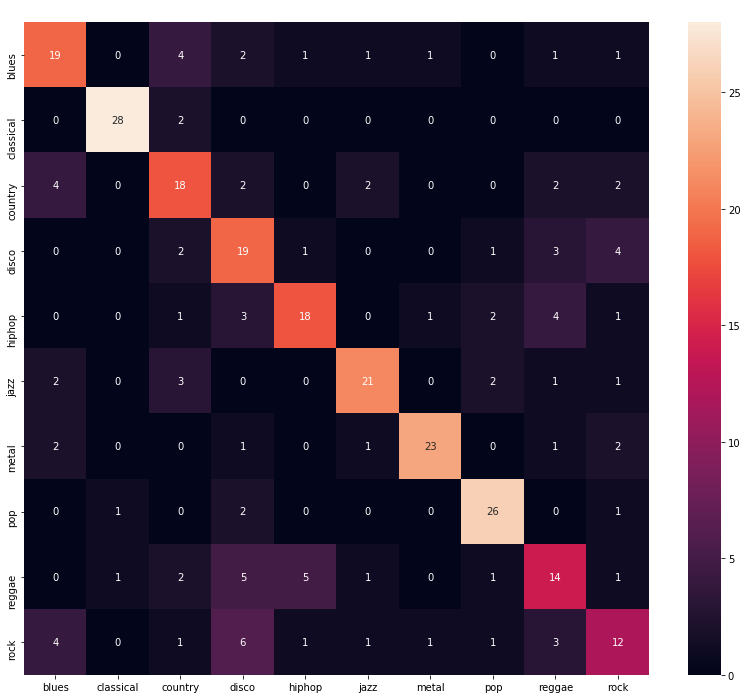

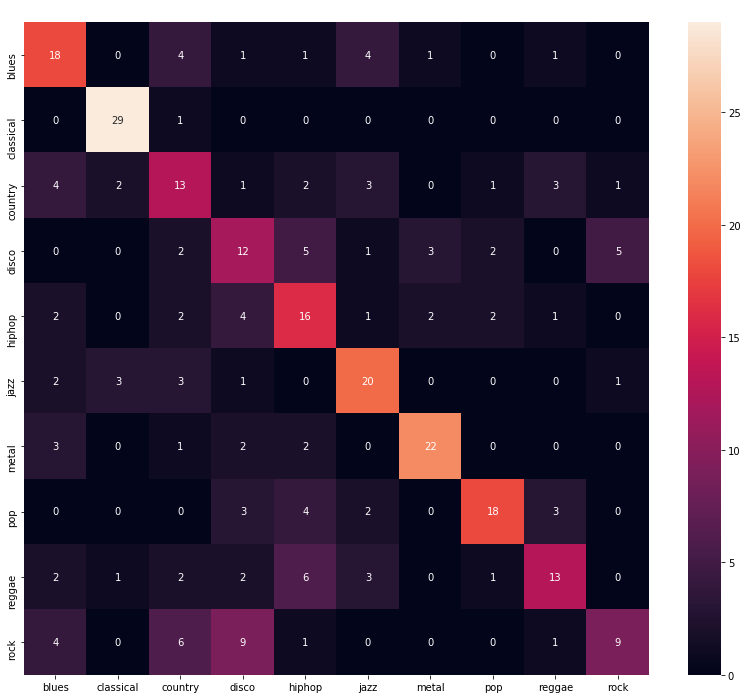

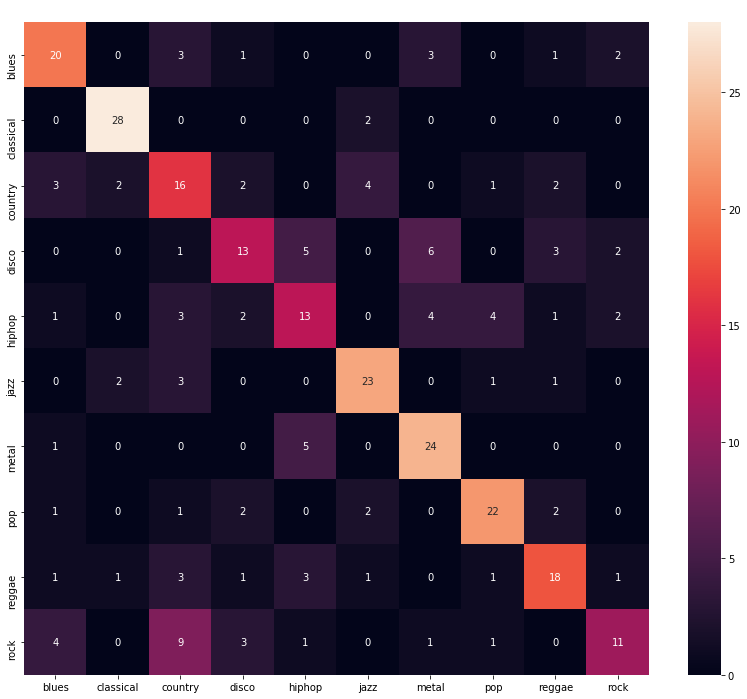

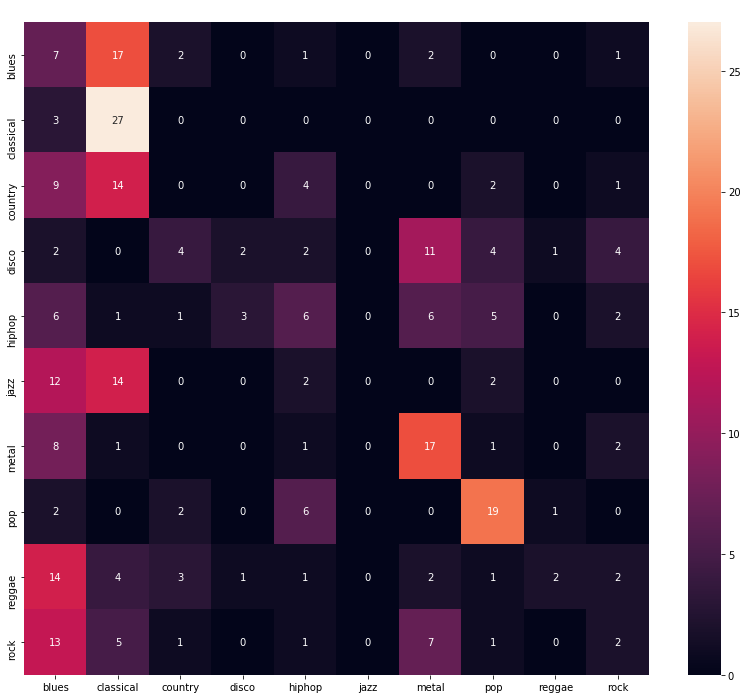

In [36]:
#Confusion matrices plots
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
cm = confusion_matrix(y_test, y_predict_lr)
cm_df = pd.DataFrame(cm, index = genres, columns = genres)
plt.figure(figsize = (14, 12))
plt.title("Logistic regression before hyperparameter tuning confusion matrix", c = "white")
sn.heatmap(cm_df, annot = True, xticklabels = False)
plt.show()

cm = confusion_matrix(y_test, y_pred_best_lr)
cm_df = pd.DataFrame(cm, index = genres, columns = genres)
plt.figure(figsize = (14, 12))
plt.title("Logistic regression after hyperparameter tuning confusion matrix", c = "white")
sn.heatmap(cm_df, annot = True)
plt.show()

cm = confusion_matrix(y_test, y_predict_rf)
cm_df = pd.DataFrame(cm, index = genres, columns = genres)
plt.figure(figsize = (14, 12))
plt.title("Random Forest before hyperparameter tuning confusion matrix", c = "white")
sn.heatmap(cm_df, annot = True)
plt.show()

cm = confusion_matrix(y_test, y_pred_best_rf)
cm_df = pd.DataFrame(cm, index = genres, columns = genres)
plt.figure(figsize = (14, 12))
plt.title("Random Forest after hyperparameter tuning confusion matrix", c = "white")
sn.heatmap(cm_df, annot = True)
plt.show()

cm = confusion_matrix(y_test, y_pred_svm)
cm_df = pd.DataFrame(cm, index = genres, columns = genres)
plt.figure(figsize = (14, 12))
plt.title("SVM confusion matrix", c = "white")
sn.heatmap(cm_df, annot = True)
plt.show()

In [31]:
y_pred_rf = model_rf.predict(X_test)
print(model_rf.score(X_test,  y_test))

0.5666666666666667


In [75]:
def predict_genre(audio_path):
    x, sr = librosa.load(audio_path, mono = True, duration = 30)
    
    #ipd.Audio(audio_path)
    plt.figure(figsize = (14, 10))
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency")
    a, b, c, dB = plt.specgram(x, NFFT = 2048, Fs = 2, scale = 'dB');
    plt.colorbar(dB).set_label("Amplitude (dB)")
    plt.figure(figsize=(14, 5))

    librosa.display.waveplot(x, sr = sr)
    
    rms = librosa.feature.rms(x)
    chroma_stft = librosa.feature.chroma_stft(x, sr)
    spectral_centroid = librosa.feature.spectral_centroid(x, sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(x, sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(x, sr)
    mfcc = librosa.feature.mfcc(x, sr)
    
    X = pd.DataFrame({"chroma_fq" : [np.mean(chroma_stft)], "rmse" : [np.mean(rms)], 
                      "spectral_centroid" : [np.mean(spectral_centroid)], 
                      "spectral_bandwith" : [np.mean(spectral_bandwidth)],
                      "spectral_rolloff" : [np.mean(spectral_rolloff)], 
                      "zero_crossing_point" : [np.mean(zero_crossing_rate)]})
        
    i = 1
    for ce in mfcc:
        X.insert(5 + i, "mfcc{}".format(i), np.mean(ce))
        i += 1

    genre = model.predict(X)
    
    return genre

['country']


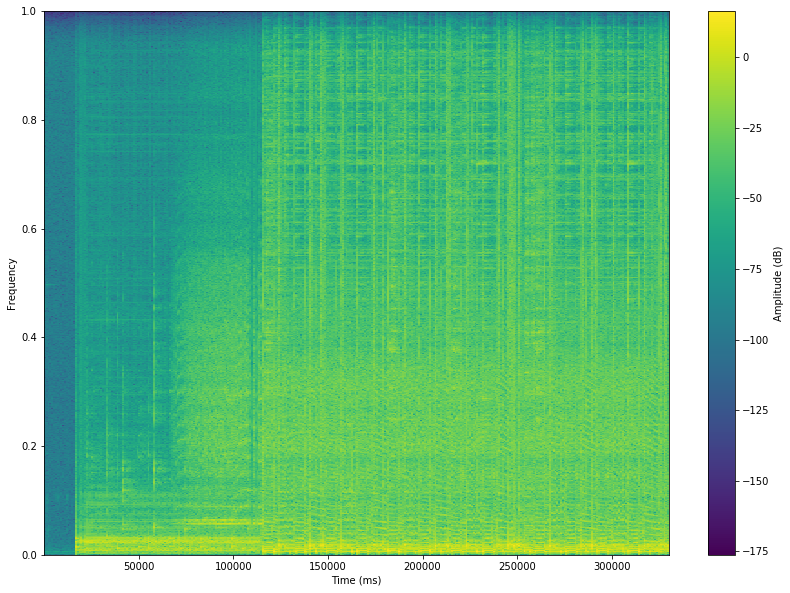

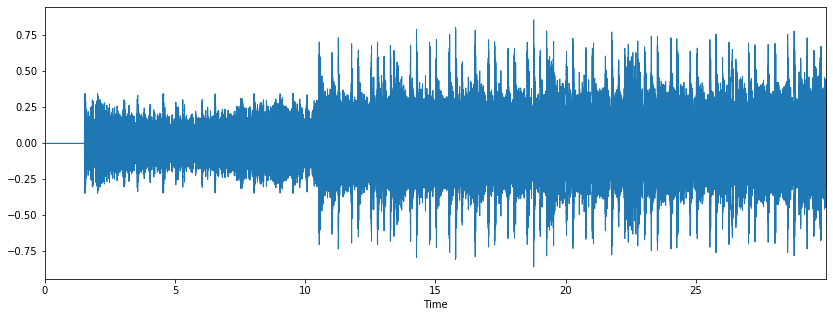

In [76]:
print(predict_genre('/home/arek/kodzik/data_science/music_genre_classification/Sage.wav'))

ValueError: not enough values to unpack (expected 2, got 1)